### Step 1. Parsing and Opening Data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

from IPython.display import display

try:
    df_weather = pd.read_csv('../datasets/project_sql_result_07.csv')
    display(df.sample(5))
except:
    print("Data not found")

,start_ts,weather_conditions,duration_seconds
165,2017-11-18 13:00:00,Bad,2940.0
930,2017-11-11 12:00:00,Good,1800.0
612,2017-11-11 08:00:00,Good,1320.0
752,2017-11-04 06:00:00,Good,1532.0
993,2017-11-04 16:00:00,Bad,2580.0


In [30]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [31]:
try:
    df_trips = pd.read_csv('../datasets/project_sql_result_01.csv')
except:
    df_trips = pd.read_csv('/datasets/project_sql_result_01.csv','\t')

df_trips.sample(5)

,company_name,trips_amount
28,5 Star Taxi,310
45,3011 - 66308 JBL Cab Inc.,25
27,Service Taxi Association,402
7,Sun Taxi,7701
54,2192 - 73487 Zeymane Corp,14


In [32]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [33]:
try:
    df_average = pd.read_csv('../datasets/project_sql_result_04.csv')
except:
    df_average = pd.read_csv('/datasets/project_sql_result_04.csv','\t')

df_average.sample(5)

,dropoff_location_name,average_trips
67,Auburn Gresham,15.166667
39,Jefferson Park,74.333333
18,West Town,516.400000
85,Montclare,5.766667
50,South Shore,40.533333


In [34]:
df_average.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


### Step 2. Data Preprocessing

In [35]:
# binary encode weather column
def weather_id(row):
    if row['weather_conditions'] == "Bad":
        return 0
    else:
        return 1

df_weather['weather_condition_id'] = df_weather.apply(weather_id,axis=1)
df_weather['weather_condition_id'].value_counts()

1    888
0    180
Name: weather_condition_id, dtype: int64

In all data frames we see undercase columns and correct data types.

In [36]:
dfs = [df_trips,df_average,df_weather]
for df in dfs:    
    display(df[df.duplicated() == True].count())

company_name    0
trips_amount    0
dtype: int64

dropoff_location_name    0
average_trips            0
dtype: int64

start_ts                197
weather_conditions      197
duration_seconds        197
weather_condition_id    197
dtype: int64

In [37]:
# dropping found duplicates
df_weather.drop_duplicates(inplace=True)

for df in dfs:
    display(df.isna().sum())

company_name    0
trips_amount    0
dtype: int64

dropoff_location_name    0
average_trips            0
dtype: int64

start_ts                0
weather_conditions      0
duration_seconds        0
weather_condition_id    0
dtype: int64

No nulls found in either dataframe and duplicates dropped.

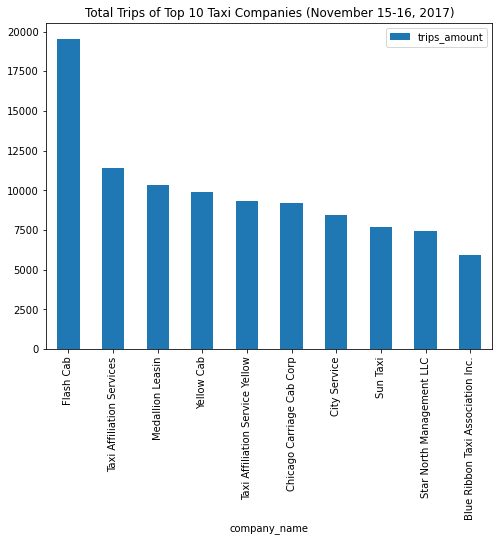

In [38]:
df_trips.head(10).plot(x='company_name',y='trips_amount',kind="bar",figsize=(8,6))
plt.suptitle("")
plt.title("Total Trips of Top 10 Taxi Companies (November 15-16, 2017)")
plt.show()

Ordinary graph of total trips by company, clear leader in Flash Cab. With a look on their website they have existed since 1945 so they seem to be the established local company. Other companies have similar trip totals.

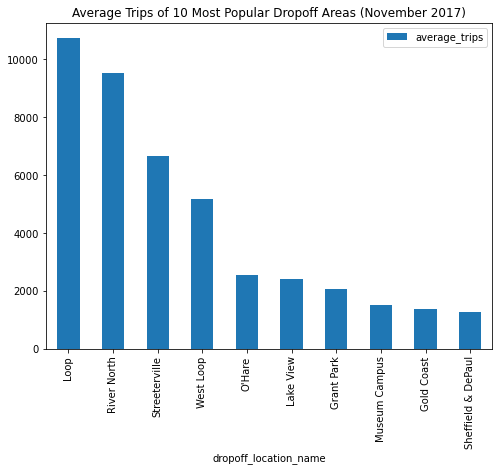

In [39]:
df_average.head(10).plot(x='dropoff_location_name',y='average_trips',kind="bar",figsize=(8,6))
plt.suptitle("")
plt.title("Average Trips of 10 Most Popular Dropoff Areas (November 2017)")
plt.show()

By looking at a map of Chicago, all the top 4 areas by average trips are bordering. This is the downtown core.

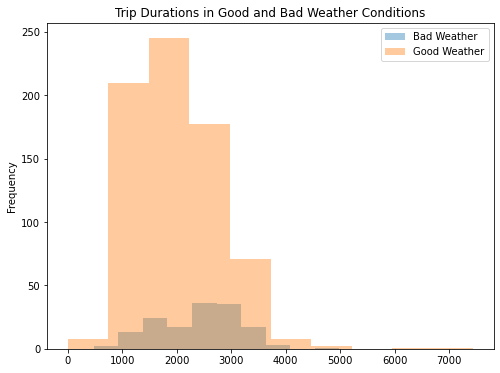

In [40]:
(
    df_weather
    .groupby('weather_condition_id')['duration_seconds']
    .plot(kind='hist',alpha=0.4,figsize=(8,6))
)

plt.suptitle("")
plt.title("Trip Durations in Good and Bad Weather Conditions")
plt.legend(['Bad Weather','Good Weather'])
plt.show()

There is far more data available for good weather but it looks less varied and a sharp peaked distribution. The graph indicates some outliers in trip_duration that I will slice out to get more accurate look.

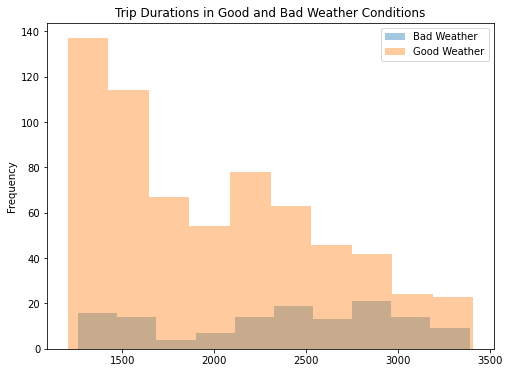

In [41]:
min_durations = df_weather['duration_seconds'].quantile(0.05)
max_durations = df_weather['duration_seconds'].quantile(0.95)

df_weather = df_weather.query("@min_durations < duration_seconds < @max_durations")
(
    df_weather
    .groupby('weather_condition_id')['duration_seconds']
    .plot(kind='hist',alpha=0.4,figsize=(8,6))
)

plt.suptitle("")
plt.title("Trip Durations in Good and Bad Weather Conditions")
plt.legend(['Bad Weather','Good Weather'])
plt.show()

We can now see more clearly that the good weather trip durations have a poisson distribution while the bad weather durations have a flat platykurtic distribution.

All relevant data has been imported to dataframes with no nulls or duplicate and we can see the leading taxi cab companies and popular drop-off areas (indicating the downtown core of Chicago).

### Step 3. Testing hypotheses 

Test hypothesis on "the average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays". 

Without the test I would assume that bad weather taxi rides take longer because people drive more carefully or slower and it causes more traffic. It was also apparent in the previous steps graph that their distributions have marked differences. The null hypothesis is that there is no statistically significant difference between travel duration on good and bad weather days. The alternative hypothesis is that there is a statistically significant difference between travel duration on good and bad weather days.

In [42]:
df_bad = df_weather.query('weather_condition_id == 0')
df_good = df_weather.query('weather_condition_id == 1')
                
print("The variance of trip durations in bad weather = {:.2f}".format(np.var(df_bad['duration_seconds'])))
print("The variance of trip durations on good weather = {:.2f}".format(np.var(df_good['duration_seconds'])))

The variance of trip durations in bad weather = 369458.68
The variance of trip durations on good weather = 348473.94


Bad weather trip durations have more variance. Using alpha of 1% because it will indicate a significant difference.

In [43]:
alpha = .01 # critical statistical significance level, if the p-value is less than alpha, we reject the hypothesis

# Calculate the p-value with equal_val as True
# The variances of the statistical populations from which the samples are different
results = st.ttest_ind(
        df_bad['duration_seconds'], 
        df_good['duration_seconds'],
        equal_var = False)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value:  7.593338311006286e-09
We reject the null hypothesis


This indicates that there is a statistically significant difference between trip durations in good and bad weather conditions. Choosing an alpha of 5% would not have made a difference in the result of the hypothesis test.

### Conclusion

We tested the hypotheses on the trip durations between weather conditions and as a result rejected the null hypothesis, indicating a statistically significant difference between trip durations in good and bad weather conditions. This makes sense logically that weather effects a taxi ride duration due to traffic and could be seen in the stark difference between the distributions on their respective graphs.